In [2]:
from pprint import pprint

from wetterdienst import Settings
from wetterdienst import Parameter, Resolution
from wetterdienst.provider.dwd.observation import (
    DwdObservationRequest,
    DwdObservationPeriod,
    DwdObservationResolution,
    DwdObservationParameter,
    DwdObservationDataset,
)

import logging
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps
import numpy as np
import polars as pl
import pandas as pd
import seaborn as sns
import plotly.express as px

In [3]:
from wetterdienst.provider.dwd.observation import DwdObservationRequest
from datetime import datetime
from wetterdienst import Parameter, Resolution

stations = DwdObservationRequest( 
    parameter=Parameter.WIND_SPEED,      ##############TEMPERATURE_AIR_MEAN_200                           <<< IMPORTANT HEHEHE
    resolution=Resolution.DAILY,
    start_date=datetime(2020, 9, 14),
    end_date=datetime(2023, 9, 4),
)


result = stations.summarize_by_station_id(station_id="01078")

df_dusseldorf_wind = result.df

### This notebook covers cluster in this notebook = ['40', '41', '42', '44', '45', '46', '47'] and the correlation between Price and Weather data. For Weather data, we used DwD to get both windspeed and temperature data.
### This cluster contains three product categores, A1 and A2, A2 and A3 and A3. First we extract the weather data - choosing dusseldorf as our station, since it is originated in the centre of the cluster. Afterwards, we clean/shape the data so that we can find correlation between Price and weather. 

In [34]:
######## Extracting temperature data using DWD - we chose Dusseldorf as our station, based on the cluster that I am dealing with.

from wetterdienst.provider.dwd.observation import DwdObservationRequest
from datetime import datetime
from wetterdienst import Parameter, Resolution

stations = DwdObservationRequest( 
    parameter=Parameter.TEMPERATURE_AIR_MEAN_200,      ##############TEMPERATURE_AIR_MEAN_200    and WIND_SPEED for our goal
    resolution=Resolution.DAILY,
    start_date=datetime(2020, 9, 14),                    ### Date as need be
    end_date=datetime(2023, 9, 4),
)


result = stations.summarize_by_station_id(station_id="01078")   ### this is the station ID for dusseldorf. 

df_dusseldorf_temper = result.df

In [ ]:
#### Similarly, now for windspeed.
from wetterdienst.provider.dwd.observation import DwdObservationRequest
from datetime import datetime
from wetterdienst import Parameter, Resolution

stations = DwdObservationRequest( 
    parameter=Parameter.WIND_SPEED,      ##############WINDSPEED 
    resolution=Resolution.DAILY,
    start_date=datetime(2020, 9, 14),
    end_date=datetime(2023, 9, 4),
)


result = stations.summarize_by_station_id(station_id="01078")

df_dusseldorf_wind = result.df

In [35]:
df_dusseldorf_temper['value'] = df_dusseldorf_temper['value'] - 273.15 #### converting from kelvin to celsius

In [36]:
df_dusseldorf_temper.rename(columns={'value':'temperature'}, inplace=True)

In [37]:
df_dusseldorf_wind.rename(columns={'value':'windspeed'}, inplace=True)

In [38]:
merged_df = pd.merge(df_dusseldorf_temper, df_dusseldorf_wind[['windspeed']], left_index=True, right_index=True)


In [39]:
merged_df.reset_index(inplace=True)

In [40]:
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Create a new DataFrame with only 'date' column
date_df = merged_df[['date']].set_index('date')

df_weekly = date_df.resample('W-Mon', origin='epoch').sum()

# Merge the resampled DataFrame back with the original DataFrame
result_df = pd.merge(merged_df, df_weekly, left_on='date', right_index=True)

In [41]:
result_df.dtypes

index                        int64
date           datetime64[ns, UTC]
parameter                   object
temperature                float64
distance                   float64
station_id                  object
windspeed                  float64
dtype: object

In [42]:
result_df.drop(['station_id', 'distance', 'parameter'], axis=1, inplace=True)

In [43]:
df = pd.read_excel('df.xlsx')       #### Loading the data from the project now

In [44]:
df = df[(df['Plz'] == "['40', '41', '42', '44', '45', '46', '47']")] ### Only keeping designated cluster

In [45]:
df.drop(columns={'week'}, axis=1, inplace=True)

In [46]:
df.dtypes

wPreis           float64
Plz               object
full              object
date      datetime64[ns]
dtype: object

In [47]:
result_df.dtypes

index                        int64
date           datetime64[ns, UTC]
temperature                float64
windspeed                  float64
dtype: object

In [48]:
result_df['date'] = result_df['date'].astype('datetime64[ns]')

C:\Users\husna\AppData\Local\Temp\ipykernel_30032\3827078976.py:1: FutureWarning:

Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead



In [49]:
merged_df_final = pd.merge(df, result_df[['date', 'temperature', 'windspeed']], on='date', how='left')

In [50]:
merged_df_final.to_csv('weatherandpricedata.csv')

In [ ]:
merged_df_final

### Some visualizations, showing the correlation of product with Windspeed and Temperature


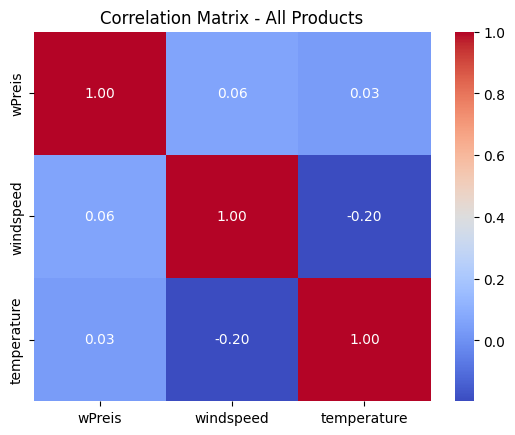

In [51]:
corr_matrix = merged_df_final[['wPreis', 'windspeed', 'temperature']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix - All Products')
plt.show()

In [52]:
corr_matrix

,wPreis,windspeed,temperature
wPreis,1.000000,0.060959,0.034476
windspeed,0.060959,1.000000,-0.197082
temperature,0.034476,-0.197082,1.000000


In [53]:
correlation_wPreis_windspeed = corr_matrix.loc['wPreis', 'windspeed']
correlation_wPreis_temperature = corr_matrix.loc['wPreis', 'temperature']

Correlation between wPreis and windspeed: 0.06
Correlation between wPreis and temperature: 0.03


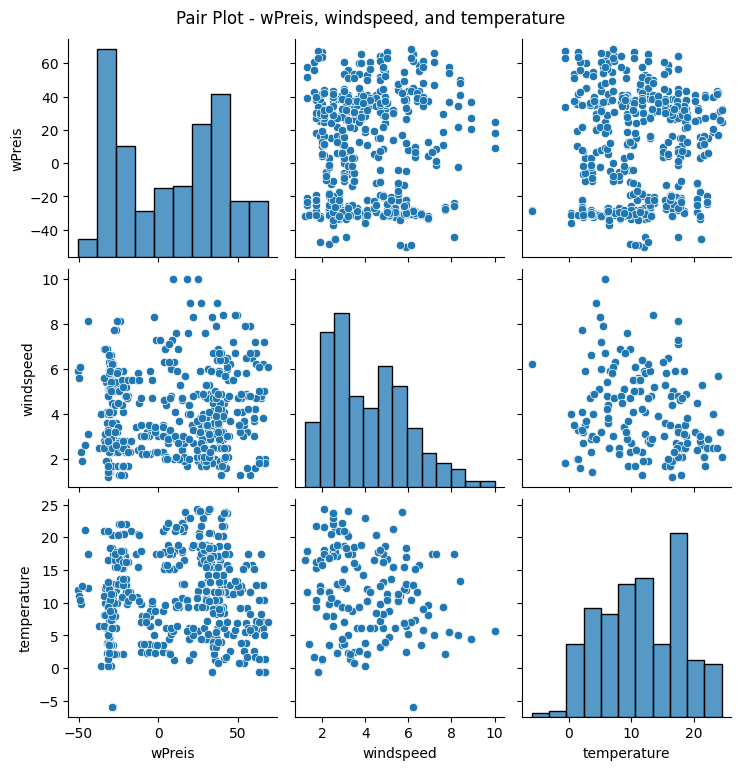

In [54]:
print(f'Correlation between wPreis and windspeed: {correlation_wPreis_windspeed:.2f}')
print(f'Correlation between wPreis and temperature: {correlation_wPreis_temperature:.2f}')

# Visualize the correlations using a pair plot
sns.pairplot(merged_df_final[['wPreis', 'windspeed', 'temperature']])
plt.suptitle('Pair Plot - wPreis, windspeed, and temperature', y=1.02)
plt.show()

In [70]:
fig = px.line(merged_df_final, x='date', y=['wPreis'], color='full', title='Price Over Time by Product')
fig.show()

### From here on, we have further separated the products so that they can be looked at individually.

In [77]:
df_A1A2 = merged_df_final[(merged_df_final['full'] == 'A1 & A2 -  geschreddert')]
df_A1A2.reset_index(drop=True)

,wPreis,Plz,full,date,temperature,windspeed
0,-44.136754,"['40', '41', '42', '44', '45', '46', '47']",A1 & A2 - geschreddert,2020-09-28,12.2,3.1
1,-50.400996,"['40', '41', '42', '44', '45', '46', '47']",A1 & A2 - geschreddert,2020-10-05,12.0,5.9
2,-48.547511,"['40', '41', '42', '44', '45', '46', '47']",A1 & A2 - geschreddert,2020-10-12,9.8,2.3
3,-33.411092,"['40', '41', '42', '44', '45', '46', '47']",A1 & A2 - geschreddert,2020-10-19,10.0,2.7
4,-49.465217,"['40', '41', '42', '44', '45', '46', '47']",A1 & A2 - geschreddert,2020-10-26,11.1,5.6
...,...,...,...,...,...,...
146,9.779891,"['40', '41', '42', '44', '45', '46', '47']",A1 & A2 - geschreddert,2023-08-07,15.1,6.3
147,15.692798,"['40', '41', '42', '44', '45', '46', '47']",A1 & A2 - geschreddert,2023-08-14,21.0,3.0
148,16.299358,"['40', '41', '42', '44', '45', '46', '47']",A1 & A2 - geschreddert,2023-08-21,21.6,2.1
149,12.919885,"['40', '41', '42', '44', '45', '46', '47']",A1 & A2 - geschreddert,2023-08-28,15.8,2.0


In [62]:
df_A2A3 = merged_df_finalA1A2 = merged_df_final[(merged_df_final['full'] == 'A2 & A3 -  geschreddert')]
df_A2A3.reset_index(drop=True)

,wPreis,Plz,full,date,temperature,windspeed
0,-45.783077,"['40', '41', '42', '44', '45', '46', '47']",A2 & A3 - geschreddert,2020-09-14,21.1,2.6
1,-31.691897,"['40', '41', '42', '44', '45', '46', '47']",A2 & A3 - geschreddert,2020-09-21,16.5,1.2
2,-33.440894,"['40', '41', '42', '44', '45', '46', '47']",A2 & A3 - geschreddert,2020-09-28,12.2,3.1
3,-31.132385,"['40', '41', '42', '44', '45', '46', '47']",A2 & A3 - geschreddert,2020-10-05,12.0,5.9
4,-31.006859,"['40', '41', '42', '44', '45', '46', '47']",A2 & A3 - geschreddert,2020-10-12,9.8,2.3
...,...,...,...,...,...,...
151,6.567629,"['40', '41', '42', '44', '45', '46', '47']",A2 & A3 - geschreddert,2023-08-07,15.1,6.3
152,10.667292,"['40', '41', '42', '44', '45', '46', '47']",A2 & A3 - geschreddert,2023-08-14,21.0,3.0
153,11.349327,"['40', '41', '42', '44', '45', '46', '47']",A2 & A3 - geschreddert,2023-08-21,21.6,2.1
154,5.542679,"['40', '41', '42', '44', '45', '46', '47']",A2 & A3 - geschreddert,2023-08-28,15.8,2.0


In [63]:
df_A3 = merged_df_finalA1A2 = merged_df_final[(merged_df_final['full'] == 'A3 -  geschreddert')]
df_A3.reset_index(drop=True)

,wPreis,Plz,full,date,temperature,windspeed
0,-45.783077,"['40', '41', '42', '44', '45', '46', '47']",A3 - geschreddert,2020-09-14,21.1,2.6
1,-31.691897,"['40', '41', '42', '44', '45', '46', '47']",A3 - geschreddert,2020-09-21,16.5,1.2
2,-32.208389,"['40', '41', '42', '44', '45', '46', '47']",A3 - geschreddert,2020-09-28,12.2,3.1
3,-26.762905,"['40', '41', '42', '44', '45', '46', '47']",A3 - geschreddert,2020-10-05,12.0,5.9
4,-28.922455,"['40', '41', '42', '44', '45', '46', '47']",A3 - geschreddert,2020-10-12,9.8,2.3
...,...,...,...,...,...,...
150,3.923720,"['40', '41', '42', '44', '45', '46', '47']",A3 - geschreddert,2023-08-07,15.1,6.3
151,3.147852,"['40', '41', '42', '44', '45', '46', '47']",A3 - geschreddert,2023-08-14,21.0,3.0
152,4.874907,"['40', '41', '42', '44', '45', '46', '47']",A3 - geschreddert,2023-08-21,21.6,2.1
153,4.106118,"['40', '41', '42', '44', '45', '46', '47']",A3 - geschreddert,2023-08-28,15.8,2.0


In [79]:
# Convert columns to numeric type (handling any non-numeric values)
df_A1A2[['wPreis', 'temperature', 'windspeed']] = df_A1A2[['wPreis', 'temperature', 'windspeed']].apply(pd.to_numeric, errors='coerce')

# Create a line plot
fig = px.line(df_A1A2, x='date', y=['wPreis', 'temperature', 'windspeed'],
              title='Price, Temperature, and Windspeed - A1 and A2')

# Show the plot
fig.show()

C:\Users\husna\AppData\Local\Temp\ipykernel_30032\1274466956.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [81]:
# Convert columns to numeric type (handling any non-numeric values)
df_A2A3[['wPreis', 'temperature', 'windspeed']] = df_A2A3[['wPreis', 'temperature', 'windspeed']].apply(pd.to_numeric, errors='coerce')

# Create a line plot
fig = px.line(df_A2A3, x='date', y=['wPreis', 'temperature', 'windspeed'],
              title='Price, Temperature, and Windspeed - A2 and A3')

# Show the plot
fig.show()

C:\Users\husna\AppData\Local\Temp\ipykernel_30032\2327872216.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [82]:
# Convert columns to numeric type (handling any non-numeric values)
df_A3[['wPreis', 'temperature', 'windspeed']] = df_A3[['wPreis', 'temperature', 'windspeed']].apply(pd.to_numeric, errors='coerce')

# Create a line plot
fig = px.line(df_A3, x='date', y=['wPreis', 'temperature', 'windspeed'],
              title='Price, Temperature, and Windspeed - A3')

# Show the plot
fig.show()

C:\Users\husna\AppData\Local\Temp\ipykernel_30032\2940020532.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Correlation plot for each product category

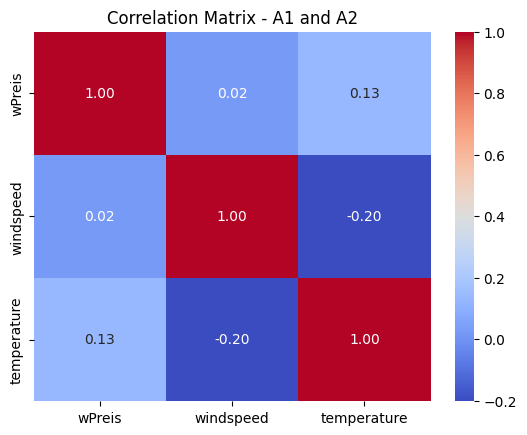

In [83]:
corr_matrixA1A2 = df_A1A2[['wPreis', 'windspeed', 'temperature']].corr()
sns.heatmap(corr_matrixA1A2, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix - A1 and A2')
plt.show()

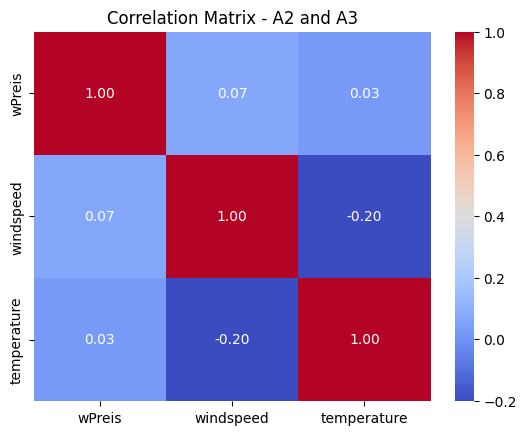

In [84]:
corr_matrixA2A3 = df_A2A3[['wPreis', 'windspeed', 'temperature']].corr()
sns.heatmap(corr_matrixA2A3, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix - A2 and A3')
plt.show()

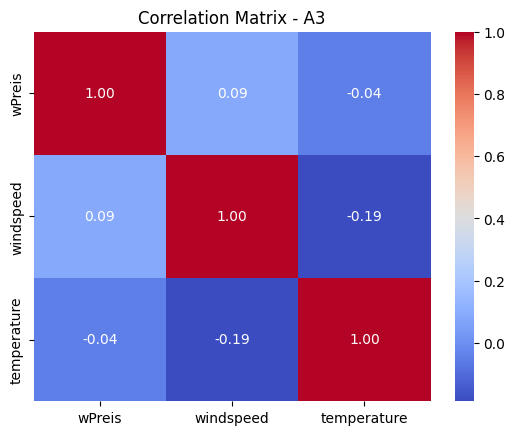

In [85]:
corr_matrixA3 = df_A3[['wPreis', 'windspeed', 'temperature']].corr()
sns.heatmap(corr_matrixA3, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix - A3')
plt.show()

## Since there is no significant correlation - doing a lag sequence is not optimal and ultimately the result is to dispose both windspeed and temperature from the equation.